## Load the data

In [2]:
"""
    Download and save raw market data CSV
"""

import pandas as pd
import logging
import os

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Download and save CSV. One time only
logger.info("Downloading power data...")
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"

df = pd.read_csv(url)
logger.info("Saving to data/power_data_raw.csv")
os.makedirs("data", exist_ok=True)
df.to_csv("data/power_data_raw.csv", index=False)

logger.info("Process completed.")

2025-11-13 14:37:47,410 | INFO | Downloading power data...
2025-11-13 14:37:59,536 | INFO | Saving to data/power_data_raw.csv
2025-11-13 14:38:02,880 | INFO | Process completed.


## Get Austria's Values

In [3]:
df = pd.read_csv("data/power_data_raw.csv")
print(df.head())
with open("all_column_names.txt", "w") as f:
    for col in df.columns:
        f.write(f"{col}\n")

          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Columns: 300 entries, utc_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(2)
memory usage: 115.4+ MB


In [5]:
at_cols = df.columns[df.columns.str.startswith("AT_")]
selected_cols = ["utc_timestamp", "cet_cest_timestamp"] + list(at_cols) # Desired Columns
df_selected = df[selected_cols].copy()
df_selected["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"]) # Datetime Timestamp
df_selected = df_selected.set_index("utc_timestamp") # Timestamp as index
print(df_selected.head(1))

                                 cet_cest_timestamp  \
utc_timestamp                                         
2014-12-31 23:00:00+00:00  2015-01-01T00:00:00+0100   

                           AT_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   

                           AT_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2014-12-31 23:00:00+00:00                                   NaN   

                           AT_price_day_ahead  AT_solar_generation_actual  \
utc_timestamp                                                               
2014-12-31 23:00:00+00:00                 NaN                         NaN   

                           AT_wind_onshore_generation_actual  
utc_timestamp                                                 
2014-12-31 23:00:00+00:00                                NaN  


### Clean AT_price_day_ahead

In [6]:
df_selected["AT_price_day_ahead"] = df_selected["AT_price_day_ahead"].ffill()
df_selected = df_selected.dropna(subset=["AT_price_day_ahead"])

In [7]:
print(df_selected["AT_price_day_ahead"].isna().sum())

0


### Clean AT_wind_onshore_generation_actual

In [8]:
print(df_selected["AT_load_actual_entsoe_transparency"].isna().sum())

0


In [9]:
print(df_selected["AT_wind_onshore_generation_actual"].isna().sum())

48


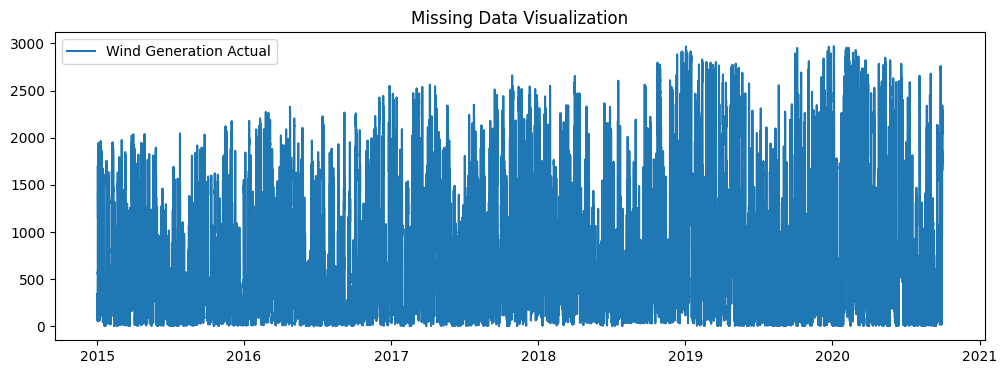

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_selected["AT_wind_onshore_generation_actual"], label="Wind Generation Actual")
plt.title("Missing Data Visualization")
plt.legend()
plt.show()

In [11]:
df_selected["AT_wind_onshore_generation_actual"] = pd.to_numeric(df_selected["AT_wind_onshore_generation_actual"])

df_selected["AT_wind_onshore_generation_actual"] = df_selected["AT_wind_onshore_generation_actual"].interpolate()
print(df_selected["AT_wind_onshore_generation_actual"].isna().sum())

0


## Feature Engineering

### Lagged price (previous hour)

In [ ]:
df_selected["AT_price_day_ahead_lag1"] = df_selected["AT_price_day_ahead"].shift(1)

### 24-hour SMA and 24-hour EMA for load

In [ ]:
df_selected["AT_load_rolling24h"] = df_selected["AT_load_actual_entsoe_transparency"].rolling(window=24).mean()
df_selected["AT_load_rolling24h"] = df_selected["AT_load_actual_entsoe_transparency"].ewm(span=24, adjust=False).mean()

### Hour and weekday

In [19]:
df_selected["hour"] = df_selected.index.hour
df_selected["weekday"] = df_selected.index.dayofweek